# Regression Comparison

In [1]:
import os
import time
import csv
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shutil
import numpy as np
from pyspark.sql import functions as sql_f
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, month, lag
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.storagelevel import StorageLevel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

## Auxiliary Functions

In [2]:
BASE_OUTPUT_DIR = "saved_models"
MASTER_LOG_FILE = "model_comparison.csv"
BASE_DATA_PATH = "processed_data"

def add_seasonal_features(df):
    df = df.withColumn("MONTH", month(col("DATE")))
    # Ajustamos el mes según el hemisferio para que el "invierno" sea comparable
    # Si lat < 0 (Sur), desplazamos 6 meses.
    df = df.withColumn("month_adj", 
        sql_f.when(sql_f.col("latitude") < 0, (sql_f.col("MONTH") + 5) % 12 + 1)
         .otherwise(sql_f.col("month"))
    )
    df = df.withColumn(
        "Solid_PRCP", 
        when((col("PRCP") > 0) & (col("TEMP") < 2.0), col("PRCP")).otherwise(0.0)
    )
    
    # Creamos las variables cíclicas
    df = df.withColumn("month_sin", sql_f.sin(2 * np.pi * sql_f.col("month_adj") / 12))
    df = df.withColumn("month_cos", sql_f.cos(2 * np.pi * sql_f.col("month_adj") / 12))
    
    return df.drop("month_adj", "month") # Limpiamos la temporal

def get_paths(years):
    """Generates file paths for the specific years."""
    return [f"{BASE_DATA_PATH}/climate_{y}.parquet" for y in years]

def save_training_history(model, output_dir, model_name):
    """
    Extracts iteration history (Objective History) if available.
    Works specifically for LinearRegression.
    """
    history_path = os.path.join(output_dir, "training_history.csv")
    
    if hasattr(model, "summary") and hasattr(model.summary, "objectiveHistory"):
        history = model.summary.objectiveHistory
        
        df_hist = pd.DataFrame({
            "Iteration": range(1, len(history) + 1),
            "Objective_Loss": history
        })
        df_hist.to_csv(history_path, index=False)
        print(f"   [v] Training history (Loss) saved to: {history_path}")
        
        plt.figure(figsize=(8, 4))
        plt.plot(df_hist["Iteration"], df_hist["Objective_Loss"], marker='o')
        plt.title(f"Convergence Curve - {model_name}")
        plt.xlabel("Iteration")
        plt.ylabel("Loss (Objective Function)")
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, "convergence_plot.png"))
        plt.close()
    else:
        print("   [!] This algorithm does not expose iterative history (objectiveHistory).")

def evaluate_and_log(predictions, target_col, time_taken, output_dir, model_name):
    """
    Calculates metrics, saves them to the Master CSV, and saves a local JSON.
    """
    evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")
    
    r2 = evaluator.setMetricName("r2").evaluate(predictions)
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    mae = evaluator.setMetricName("mae").evaluate(predictions)
    
    snow_subset = predictions.filter(col(target_col) > 0)
    if snow_subset.count() > 0:
        r2_snow = evaluator.setMetricName("r2").evaluate(snow_subset)
    else:
        r2_snow = 0.0

    metrics = {
        "Model": model_name,
        "Time_Sec": round(time_taken, 2),
        "R2_Global": round(r2, 4),
        "RMSE_Global": round(rmse, 4),
        "MAE_Global": round(mae, 4),
        "R2_Snow_Only": round(r2_snow, 4)
    }

    file_exists = os.path.isfile(MASTER_LOG_FILE)
    with open(MASTER_LOG_FILE, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)
    
    with open(os.path.join(output_dir, "metrics.json"), 'w') as f:
        json.dump(metrics, f, indent=4)

    print(f"\n--- METRICS ({model_name}) ---")
    print(f"R2: {r2:.4f} | RMSE: {rmse:.4f} | R2 Snow Only: {r2_snow:.4f}")
    return metrics

def plot_predictions(predictions, target_col, output_dir, model_name):
    """Generates and saves Scatter and Residual plots."""
    print("   Generating plots...")
    
    pdf = predictions.select(target_col, "prediction").sample(False, 0.05, seed=42).toPandas()
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=pdf[target_col], y=pdf["prediction"], alpha=0.3)
    plt.plot([pdf[target_col].min(), pdf[target_col].max()], 
             [pdf[target_col].min(), pdf[target_col].max()], 'r--', lw=2)
    plt.xlabel('Reality (Actual Value)')
    plt.ylabel('Prediction')
    plt.title(f'Prediction vs Reality - {model_name}')

    plt.subplot(1, 2, 2)
    residuals = pdf[target_col] - pdf["prediction"]
    sns.histplot(residuals, bins=50, kde=True)
    plt.xlabel('Error (Real - Predicted)')
    plt.title('Residuals Distribution')
    
    plt.savefig(os.path.join(output_dir, "prediction_plots.png"))
    plt.close()
    print(f"   [v] Plots saved in: {output_dir}")

## Linear Regression

--- STARTING: LinearRegression_Baseline ---
Output Directory: saved_models/LinearRegression_Baseline
1. Loading Data (Full Dataset)...


   Features (21): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP', 'month_sin', 'month_cos']


   Training Rows: 51,241,804
2. Training LinearRegression_Baseline...


/tmp/ipykernel_13692/3245659569.py:92: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='vlag')


   Training completed in 57.60 seconds.


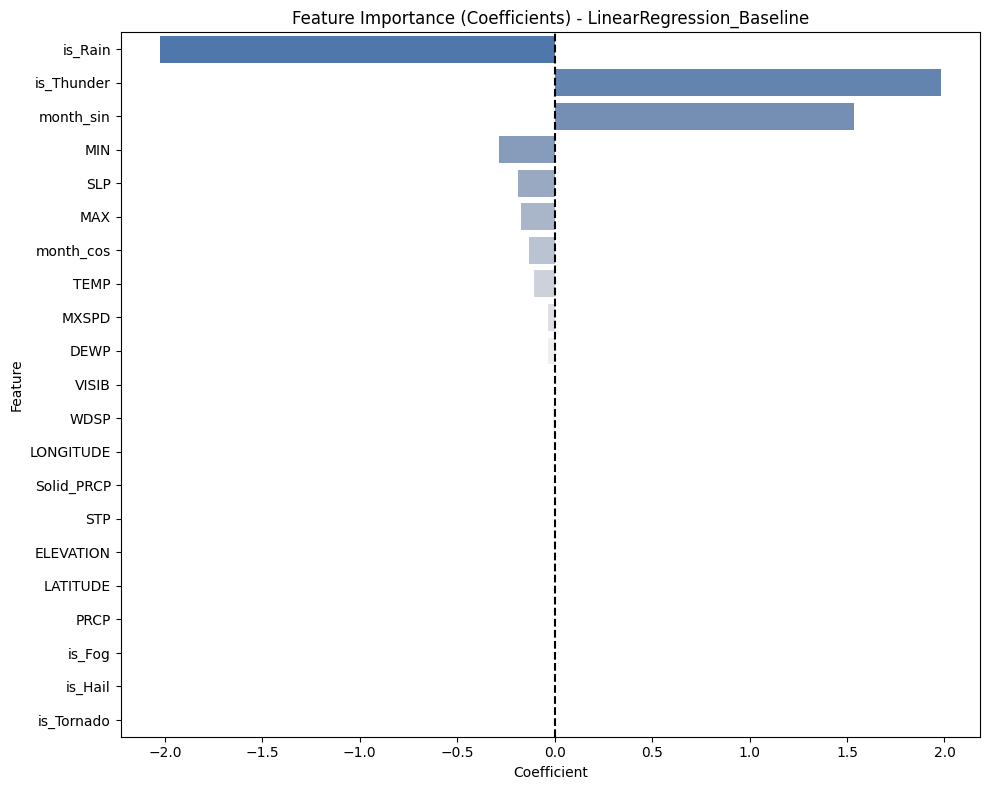


Top Variables por Coeficiente:
   Feature  Coefficient
   is_Rain    -2.026253
is_Thunder     1.982046
 month_sin     1.534287
       MIN    -0.282996
       SLP    -0.189234
       MAX    -0.170236
 month_cos    -0.132697
      TEMP    -0.106887
     MXSPD    -0.033155
      DEWP    -0.031590
     VISIB     0.011112
      WDSP    -0.007811
 LONGITUDE     0.003994
Solid_PRCP     0.003782
       STP    -0.000685
 ELEVATION     0.000448
  LATITUDE     0.000000
      PRCP     0.000000
    is_Fog     0.000000
   is_Hail     0.000000
is_Tornado     0.000000
3. Processing Results...
   [v] Spark Model saved to: saved_models/LinearRegression_Baseline/spark_model
   [v] Training history (Loss) saved to: saved_models/LinearRegression_Baseline/training_history.csv
   Generating predictions on Test Set...



--- METRICS (LinearRegression_Baseline) ---
R2: 0.3411 | RMSE: 9.6867 | R2 Snow Only: 0.0376
   Generating plots...


   [v] Plots saved in: saved_models/LinearRegression_Baseline

--- PROCESS FINISHED SUCCESSFULLY ---


In [ ]:
MODEL_NAME = "LinearRegression_Baseline"

print(f"--- STARTING: {MODEL_NAME} ---")

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.sql.files.maxPartitionBytes", "128m") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()
    

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 
test_years  = range(2023, 2025) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
    test_df  = spark.read.parquet(*get_paths(test_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

# Aplicamos la función a los tres datasets
train_df = add_seasonal_features(train_df)
val_df   = add_seasonal_features(val_df)
test_df  = add_seasonal_features(test_df)

target_col = "SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)
test_vec  = assembler.transform(test_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

lr = LinearRegression(
    featuresCol="features", 
    labelCol=target_col,
    maxIter=50, 
    regParam=0.1, 
    elasticNetParam=0.5
)

start_time = time.time()
model = lr.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

# 1. Extraer coeficientes y nombres de columnas
coefficients = model.coefficients.toArray()
attributes = feature_cols

# 2. Crear un DataFrame de Pandas para facilitar la visualización
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

# 3. Ordenar por valor absoluto (impacto real sin importar el signo)
importance_df = importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

# 4. Graficar
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='vlag')
plt.title(f'Feature Importance (Coefficients) - {MODEL_NAME}')
plt.axvline(x=0, color='black', linestyle='--') # Línea en 0 para ver positivos vs negativos
plt.tight_layout()

# Guardar la gráfica
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
plt.show()

# Mostrar el Top 10 en consola
print("\nTop Variables por Coeficiente:")
print(importance_df[['Feature', 'Coefficient']].to_string(index=False))

print("3. Processing Results...")

model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Test Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
spark.stop()

## Decision Tree

In [3]:
BASE_OUTPUT_DIR = "saved_models"     
MASTER_LOG_FILE = "model_comparison.csv" 
BASE_DATA_PATH = "processed_data"    

def get_paths(years):
    return [f"{BASE_DATA_PATH}/climate_{y}.parquet" for y in years]

def save_feature_importance(model, feature_cols, output_dir):
    """
    Extracts Feature Importance from Random Forest and saves it to CSV.
    """
    if hasattr(model, "featureImportances"):
        importances = model.featureImportances
        feature_list = []
        for i, col_name in enumerate(feature_cols):
            feature_list.append({"Feature": col_name, "Importance": float(importances[i])})
        
        df_imp = pd.DataFrame(feature_list).sort_values(by="Importance", ascending=False)
        csv_path = os.path.join(output_dir, "feature_importance.csv")
        df_imp.to_csv(csv_path, index=False)
        print(f"   [v] Feature Importance saved to: {csv_path}")
        
        print("   --- TOP 5 FEATURES ---")
        print(df_imp.head(5))
    else:
        print("   [!] This model does not support feature importance.")

def evaluate_and_log(predictions, target_col, time_taken, output_dir, model_name):
    """
    Calculates R2, RMSE, MAE, saves to Master CSV and local JSON.
    """
    evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")
    
    r2 = evaluator.setMetricName("r2").evaluate(predictions)
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    mae = evaluator.setMetricName("mae").evaluate(predictions)
    
    snow_subset = predictions.filter(col(target_col) > 0)
    if snow_subset.count() > 0:
        r2_snow = evaluator.setMetricName("r2").evaluate(snow_subset)
    else:
        r2_snow = 0.0

    metrics = {
        "Model": model_name,
        "Time_Sec": round(time_taken, 2),
        "R2_Global": round(r2, 4),
        "RMSE_Global": round(rmse, 4),
        "MAE_Global": round(mae, 4),
        "R2_Snow_Only": round(r2_snow, 4)
    }

    file_exists = os.path.isfile(MASTER_LOG_FILE)
    with open(MASTER_LOG_FILE, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)
    
    with open(os.path.join(output_dir, "metrics.json"), 'w') as f:
        json.dump(metrics, f, indent=4)

    print(f"\n--- METRICS ({model_name}) ---")
    print(f"R2: {r2:.4f} | RMSE: {rmse:.4f} | R2 Snow Only: {r2_snow:.4f}")
    return metrics

def plot_predictions(predictions, target_col, output_dir, model_name):
    """Generates and saves Scatter and Residual plots."""
    print("   Generating plots...")
    
    pdf = predictions.select(target_col, "prediction").sample(False, 0.05, seed=42).toPandas()
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=pdf[target_col], y=pdf["prediction"], alpha=0.3)
    plt.plot([pdf[target_col].min(), pdf[target_col].max()], 
             [pdf[target_col].min(), pdf[target_col].max()], 'r--', lw=2)
    plt.xlabel('Reality (Actual Value)')
    plt.ylabel('Prediction')
    plt.title(f'Prediction vs Reality - {model_name}')

    plt.subplot(1, 2, 2)
    residuals = pdf[target_col] - pdf["prediction"]
    sns.histplot(residuals, bins=50, kde=True)
    plt.xlabel('Error (Real - Predicted)')
    plt.title('Residuals Distribution')
    
    plt.savefig(os.path.join(output_dir, "prediction_plots.png"))
    plt.close()
    print(f"   [v] Plots saved in: {output_dir}")

In [3]:
import time
import sys
import os
import shutil
import numpy as np

from pyspark.sql import SparkSession
from pyspark import StorageLevel
import pyspark.sql.functions as sql_f
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

"""
PySpark ML implementation for scalability experiments
"""

BASE_DATA_PATH = "processed_data"  # adjust to your path
BASE_OUTPUT_DIR = "model_outputs"
TARGET_COL = "SNDP"      # target column
IGNORE_COLS = [TARGET_COL, "DATE", "STATION", "NAME", "features", "prediction", "FRSHTT"]
VALID_TYPES = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

MODEL_TYPE = "regression"  # "regression" or "classification"


def get_paths(years):
    return [f"{BASE_DATA_PATH}/climate_{y}.parquet" for y in years]


def evaluate_model(predictions_df, target_col, model_type):
    """
    Evaluate model predictions
    """
    if model_type == "regression":
        evaluator = RegressionEvaluator(
            labelCol=target_col,
            predictionCol="prediction",
            metricName="rmse"
        )
        rmse = evaluator.evaluate(predictions_df)
        return rmse
    else:
        evaluator = MulticlassClassificationEvaluator(
            labelCol=target_col,
            predictionCol="prediction",
            metricName="accuracy"
        )
        accuracy = evaluator.evaluate(predictions_df)
        return accuracy


def execution_decision_tree():
    # Parse arguments
    cores = 4            # number of partitions / Spark cores
    pct = 100             # percentage of training data to use

    MODEL_NAME = f"DecisionTree_cores{cores}_pct{pct}"
    print(f"\n{'='*60}")
    print(f"--- STARTING: {MODEL_NAME} ---")
    print(f"{'='*60}\n")

    # Start Spark
    spark = (
        SparkSession.builder
        .appName(MODEL_NAME)
        .master(f"local[{cores}]")
        .config("spark.driver.memory", "12g")
        .config("spark.executor.memory", "12g")
        .config("spark.sql.files.maxPartitionBytes", "128m")
        .config("spark.driver.maxResultSize", "4g")
        .getOrCreate()
    )
    spark.sparkContext.setLogLevel("ERROR")

    # Create output directory
    model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
    if os.path.exists(model_output_dir):
        shutil.rmtree(model_output_dir)
    os.makedirs(model_output_dir)

    # Define data splits
    print("1. Loading Data...")
    train_years = range(2010, 2021) 
    val_years   = range(2021, 2023) 

    print("1. Loading Data (Full Dataset)...")
    try:
        train_df = spark.read.parquet(*get_paths(train_years))
        val_df   = spark.read.parquet(*get_paths(val_years))
    except Exception as e:
        print(f"Error loading data: {e}")
        spark.stop()
        raise e

    # Aplicamos la función a los tres datasets
    train_df = add_seasonal_features(train_df)
    val_df   = add_seasonal_features(val_df)

    # Select features
    dtypes = train_df.dtypes
    feature_cols = [c for c, t in dtypes if t in VALID_TYPES and c not in IGNORE_COLS]
    print(f"   Features ({len(feature_cols)}): {feature_cols[:5]}... (showing first 5)")

    # Prepare training data
    df_train = train_df.select(feature_cols + [TARGET_COL])
    
    # Sample fraction if pct < 100
    if pct < 100:
        print(f"   Sampling {pct}% of training data...")
        df_train = df_train.sample(fraction=pct/100.0, seed=42)

    # Repartition training data
    df_train = df_train.repartition(cores)
    
    # Assemble features
    print("   Assembling features...")
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")
    train_vec = assembler.transform(df_train)
    val_vec = assembler.transform(val_df)

    # Cache and materialize
    train_vec.persist(StorageLevel.MEMORY_AND_DISK)
    train_count = train_vec.count()
    print(f"   Training Rows: {train_count:,}")
    print(f"   Partitions: {train_vec.rdd.getNumPartitions()}")

    # Build model
    print(f"\n2. Training {MODEL_NAME}...")
    if MODEL_TYPE == "regression":
        model = DecisionTreeRegressor(
            featuresCol="features",
            labelCol=TARGET_COL,
            maxDepth=15,
            seed=42
        )
    else:
        model = DecisionTreeClassifier(
            featuresCol="features",
            labelCol=TARGET_COL,
            maxDepth=15,
            seed=42
        )

    start_time = time.time()
    fitted_model = model.fit(train_vec)
    end_time = time.time()

    total_runtime = end_time - start_time
    print(f"   Training completed in {total_runtime:.2f} seconds.")

    # Save model
    print("\n3. Saving Model...")
    fitted_model.write().overwrite().save(os.path.join(model_output_dir, "spark_model"))

    # Evaluate on validation set
    print("\n4. Evaluating on Validation Set...")
    val_preds = fitted_model.transform(val_vec)
    accuracy = evaluate_model(val_preds, TARGET_COL, MODEL_TYPE)
    
    metric_name = "RMSE" if MODEL_TYPE == "regression" else "Accuracy"
    print(f"   Validation {metric_name}: {accuracy:.4f}")

    # Print summary
    print(f"\n{'='*60}")
    print(f"SUMMARY:")
    print(f"  Cores: {cores}")
    print(f"  Data fraction: {pct}%")
    print(f"  Training rows: {train_count:,}")
    print(f"  Total runtime: {total_runtime:.2f}s")
    print(f"  Validation {metric_name}: {accuracy:.4f}")
    print(f"{'='*60}\n")

    # Log results to CSV
    with open(filename, "a") as f:
        # Format: cores, pct, total_runtime, train_count, accuracy
        print(f"{cores},{pct},{total_runtime},{train_count},{accuracy}", file=f)

    # Cleanup
    train_vec.unpersist()
    spark.stop()
    
    print("--- PROCESS FINISHED ---\n")

main()

NameError: name 'main' is not defined

## Random Forest

In [ ]:
MODEL_NAME = "RandomForest_New_Features"

print(f"--- STARTING: {MODEL_NAME} ---")

# Calculate 70-80% of your total physical RAM. 
# Example: If you have 16GB RAM, use 12g for the driver.
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data...")
try:
    train_raw = spark.read.parquet(*get_paths(train_years))
    val_raw   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e


print("2. Applying Feature Engineering (Month + Solid_PRCP)...")
# Aplicamos la función a los tres datasets
train_df = add_seasonal_features(train_raw)
val_df   = add_seasonal_features(val_raw)

# THIS IS A TEST FOR MODIFICATIONS OF CHARACTERISTIC SCALES 
train_df = train_df.withColumn("weight", 
    sql_f.when(sql_f.col("SNDP") > 0, 5.0).otherwise(1.0) #weight column to feed the regressor  
)

# Apply log transform to training and val
train_df = train_df.withColumn("log_SNDP", sql_f.log1p(sql_f.col("SNDP")))
val_df = val_df.withColumn("log_SNDP", sql_f.log1p(sql_f.col("SNDP")))

# Update labelCol in RF
# target_col = "SNDP"
target_col = "log_SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "weight", "SNDP"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"3. Training {MODEL_NAME}...")

rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol=target_col,
    numTrees=20,     # Reduced slightly from 30 for stability
    weightCol="weight",
    maxDepth=8,      # Reduced slightly from 8 (Depth 8 is exponentially heavier)
    maxBins=32,      # Essential: Reduces the metadata memory spike
    seed=42
)

start_time = time.time()
model = rf.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

train_vec.unpersist() 
print("Memory released, starting evaluation...")
print("4. Processing Results...")

model.write().overwrite().save(os.path.join(model_output_dir, "spark_model"))
save_feature_importance(model, feature_cols, model_output_dir)

val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED ---")
spark.stop()

--- STARTING: RandomForest_New_Features ---
1. Loading Data...
2. Applying Feature Engineering (Month + Solid_PRCP)...
   Features (22): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP', 'month_sin', 'month_cos']


   Training Rows: 51,241,804
3. Training RandomForest_New_Features...


   Training completed in 1098.15 seconds.
Memory released, starting evaluation...
4. Processing Results...


   [v] Feature Importance saved to: saved_models/RandomForest_New_Features/feature_importance.csv
   --- TOP 5 FEATURES ---
     Feature  Importance
11       MIN    0.470056
3       TEMP    0.145491
10       MAX    0.144978
4       DEWP    0.115649
0   LATITUDE    0.074290



--- METRICS (RandomForest_New_Features) ---
R2: 0.8654 | RMSE: 0.3344 | R2 Snow Only: 0.3530
   Generating plots...


   [v] Plots saved in: saved_models/RandomForest_New_Features

--- PROCESS FINISHED ---


## GBT Regression

In [10]:
MODEL_NAME = "GBT_New_Features"

print(f"--- STARTING: {MODEL_NAME} ---")

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.sql.files.maxPartitionBytes", "128m") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 
test_years  = range(2023, 2025) 

print("1. Loading Data...")
try:
    train_raw = spark.read.parquet(*get_paths(train_years))
    val_raw   = spark.read.parquet(*get_paths(val_years))
    test_raw  = spark.read.parquet(*get_paths(test_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

print("2. Applying Feature Engineering (Month + Solid_PRCP)...")

def add_smart_features(df):
    df = df.withColumn("MONTH", month(col("DATE")))
    df = df.withColumn(
        "Solid_PRCP", 
        when((col("PRCP") > 0) & (col("TEMP") < 2.0), col("PRCP")).otherwise(0.0)
    )
    return df

train_df = add_smart_features(train_raw)
val_df   = add_smart_features(val_raw)
test_df  = add_smart_features(test_raw)

target_col = "SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "FRSHTT"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)
test_vec  = assembler.transform(test_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"3. Training {MODEL_NAME}...")

gbt = GBTRegressor(
    featuresCol="features", 
    labelCol=target_col,
    maxIter=50,         
    maxDepth=5,         
    stepSize=0.1,
    seed=42,
    subsamplingRate=0.7 
)

start_time = time.time()
model = gbt.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("4. Processing Results...")

model.write().overwrite().save(os.path.join(model_output_dir, "spark_model"))
save_feature_importance(model, feature_cols, model_output_dir)

test_preds = model.transform(test_vec)
metrics = evaluate_and_log(test_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(test_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED ---")
spark.stop()

--- STARTING: GBT_New_Features ---
1. Loading Data...
2. Applying Feature Engineering (Month + Solid_PRCP)...
   Features (21): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'MONTH', 'Solid_PRCP']


   Training Rows: 51,241,804
3. Training GBT_New_Features...


   Training completed in 8294.65 seconds.
4. Processing Results...
   [v] Feature Importance saved to: saved_models/GBT_New_Features/feature_importance.csv
   --- TOP 5 FEATURES ---
      Feature  Importance
10        MAX    0.270098
1   LONGITUDE    0.170592
0    LATITUDE    0.152985
2   ELEVATION    0.143522
19      MONTH    0.111063



--- METRICS (GBT_New_Features) ---
R2: 0.6998 | RMSE: 6.2742 | R2 Snow Only: 0.4696
   Generating plots...


   [v] Plots saved in: saved_models/GBT_New_Features

--- PROCESS FINISHED ---


## Hypertuning of Random Forest

In [3]:
BASE_OUTPUT_DIR = "optimized_models"     
MASTER_LOG_FILE = "tuning_comparison.csv" 
BASE_DATA_PATH = "processed_data"    

def get_paths(years):
    return [f"{BASE_DATA_PATH}/climate_{y}.parquet" for y in years]

def save_best_params(cv_model, output_dir):
    """
    Extracts and saves the best hyperparameters found by CrossValidator.
    """
    rf_model = cv_model.bestModel
    
    params = {
        "numTrees": rf_model.getNumTrees,
        "maxDepth": rf_model.getOrDefault("maxDepth"),
        "maxBins": rf_model.getOrDefault("maxBins"),
        "subsamplingRate": rf_model.getOrDefault("subsamplingRate")
    }
    
    with open(os.path.join(output_dir, "best_params.json"), 'w') as f:
        json.dump(params, f, indent=4)
    
    print("\n   [v] WINNING PARAMETERS SAVED:")
    print(json.dumps(params, indent=4))

def evaluate_and_log(predictions, target_col, time_taken, output_dir, model_name):
    """
    Evaluates the model on the final Test set.
    """
    evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")
    
    r2 = evaluator.setMetricName("r2").evaluate(predictions)
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    
    snow_subset = predictions.filter(col(target_col) > 0)
    r2_snow = evaluator.setMetricName("r2").evaluate(snow_subset) if snow_subset.count() > 0 else 0.0

    metrics = {
        "Model": model_name,
        "Time_Min": round(time_taken / 60, 2),
        "R2_Global": round(r2, 4),
        "RMSE_Global": round(rmse, 4),
        "R2_Snow_Only": round(r2_snow, 4)
    }

    file_exists = os.path.isfile(MASTER_LOG_FILE)
    with open(MASTER_LOG_FILE, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)

    print(f"\n--- FINAL TEST RESULTS ({model_name}) ---")
    print(f"R2 Global: {r2:.4f} | R2 Snow Only: {r2_snow:.4f}")
    return metrics

In [ ]:
MODEL_NAME = "RandomForest_HyperTuning"
print(f"--- STARTING TUNING: {MODEL_NAME} ---")

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.sql.files.maxPartitionBytes", "128m") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 
test_years  = range(2023, 2025) 

print("1. Loading and Transforming Data...")
train_raw = spark.read.parquet(*get_paths(train_years))
val_raw  = spark.read.parquet(*get_paths(val_years))

def add_features(df):
    df = df.withColumn("MONTH", month(col("DATE")))
    df = df.withColumn("Solid_PRCP", when((col("PRCP") > 0) & (col("TEMP") < 2.0), col("PRCP")).otherwise(0.0))
    return df

train_df = add_features(train_raw)
val_df  = add_features(val_raw)

target_col = "SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "FRSHTT"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features to use: {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec  = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows (Internal Train + Val): {train_vec.count():,}")

print("2. Configuring Grid Search...")

print(f"   Original Training Rows: {train_vec.count():,}")

# # --- ADD THIS SAMPLING STEP ---
# # Take 10% of data for the heavy tuning process
# train_vec_sample = train_vec.sample(False, 0.2, seed=42) 
# train_vec_sample.persist(StorageLevel.MEMORY_AND_DISK)

# print(f"   Tuning Sample Rows: {train_vec_sample.count():,}")

rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, seed=42)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 25]) \
    .addGrid(rf.maxDepth, [15, 10]) \
    .build()
    # .addGrid(rf.maxBins, [32, 64]) \

print(f"   Combinations to test: {len(paramGrid)}")

evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

# tvs = TrainValidationSplit(
#     estimator=rf,
#     estimatorParamMaps=paramGrid,
#     evaluator=evaluator,
#     trainRatio=0.8,
#     parallelism=1
# )


# print("3. Running Train-Validation Split (Please wait)...")
# start_time = time.time()

# cv_model = tvs.fit(train_vec)

# end_time = time.time()
# duration = end_time - start_time
# print(f"   Tuning completed in {duration/60:.2f} minutes!")

# print("4. Analyzing the Champion Model...")

# best_model = cv_model.bestModel

print("3. Running Time-Aware Hyperparameter Search...")
start_time = time.time()

results = []

for i, param_map in enumerate(paramGrid, 1):
    print(f"   [{i}/{len(paramGrid)}] Training with params: "
          f"numTrees={param_map[rf.numTrees]}, "
          f"maxDepth={param_map[rf.maxDepth]}")

    # Train ONLY on past data
    model = rf.copy(param_map).fit(train_vec)

    # Validate ONLY on future data
    val_preds = model.transform(val_vec)
    rmse = evaluator.evaluate(val_preds)

    print(f"       RMSE = {rmse:.4f}")

    results.append({
        "numTrees": param_map[rf.numTrees],
        "maxDepth": param_map[rf.maxDepth],
        "rmse": rmse,
        "model": model
    })

end_time = time.time()
duration = end_time - start_time

print(f"   Tuning completed in {duration/60:.2f} minutes!")

best_result = min(results, key=lambda x: x["rmse"])
best_model = best_result["model"]

print("\n4. Best Model Selected:")
print(f"   numTrees = {best_result['numTrees']}")
print(f"   maxDepth = {best_result['maxDepth']}")
print(f"   RMSE     = {best_result['rmse']:.4f}")

best_model.write().overwrite().save(
    os.path.join(model_output_dir, "spark_model_winner")
)

save_best_params(best_result, model_output_dir)

print("\n--- PROCESS FINISHED ---")
spark.stop()

--- STARTING TUNING: RandomForest_HyperTuning ---
1. Loading and Transforming Data...


   Features to use: ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'MONTH', 'Solid_PRCP']


   Training Rows (Internal Train + Val): 51,241,804
2. Configuring Grid Search...


   Original Training Rows: 51,241,804
   Combinations to test: 4
3. Running Time-Aware Hyperparameter Search...
   [1/4] Training with params: numTrees=50, maxDepth=15


       RMSE = 6.4939
   [2/4] Training with params: numTrees=50, maxDepth=10


## Lag Variables

In [9]:
def add_lag_features(df):
    # Definimos la ventana: misma estación, ordenada por tiempo
    window_spec = Window.partitionBy("STATION").orderBy("DATE")
    
    # 1. Retardo de la variable objetivo (SNDP)
    # Usamos SNDP original antes del log para que el modelo entienda la escala real
    df = df.withColumn("SNDP_lag1", sql_f.lag("SNDP", 1).over(window_spec))
    df = df.withColumn("SNDP_lag2", sql_f.lag("SNDP", 2).over(window_spec))
    
    # 2. Retardo de Temperatura (Persistencia térmica)
    # Asumiendo que tienes una columna 'TEMP'
    if "TEMP" in df.columns:
        df = df.withColumn("TEMP_lag1", sql_f.lag("TEMP", 1).over(window_spec))
    
    # 3. Diferencia de nieve (Delta) - Indica si está acumulando o derritiendo
    df = df.withColumn("SNDP_diff", sql_f.col("SNDP_lag1") - sql_f.col("SNDP_lag2"))
    
    # IMPORTANTE: Al crear LAGS, las primeras filas de cada estación tendrán NULLS
    # Debemos eliminarlas o imputarlas para que el VectorAssembler no falle
    return df.dropna(subset=["SNDP_lag1", "SNDP_lag2"])

In [11]:
MODEL_NAME = "RandomForest_Lag_Features"

print(f"--- STARTING: {MODEL_NAME} ---")

# Calculate 70-80% of your total physical RAM. 
# Example: If you have 16GB RAM, use 12g for the driver.
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data...")
try:
    train_raw = spark.read.parquet(*get_paths(train_years))
    val_raw   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e


print("2. Applying Feature Engineering (Month + Solid_PRCP)...")
# Aplicamos la función a los tres datasets
train_df = add_seasonal_features(train_raw)
val_df   = add_seasonal_features(val_raw)

# THIS IS A TEST FOR MODIFICATIONS OF CHARACTERISTIC SCALES 
train_df = train_df.withColumn("weight", 
    sql_f.when(sql_f.col("SNDP") > 0, 5.0).otherwise(1.0) #weight column to feed the regressor  
)

# Apply log transform to training and val
train_df = train_df.withColumn("log_SNDP", sql_f.log1p(sql_f.col("SNDP")))
val_df = val_df.withColumn("log_SNDP", sql_f.log1p(sql_f.col("SNDP")))

print("1.5 Adding Lag Features...")
train_df = add_lag_features(train_df)
val_df = add_lag_features(val_df)

# Update labelCol in RF
# target_col = "SNDP"
target_col = "log_SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "weight", "SNDP"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"3. Training {MODEL_NAME}...")

rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol=target_col,
    numTrees=20,     # Reduced slightly from 30 for stability
    weightCol="weight",
    maxDepth=8,      # Reduced slightly from 8 (Depth 8 is exponentially heavier)
    maxBins=32,      # Essential: Reduces the metadata memory spike
    seed=42
)

start_time = time.time()
model = rf.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

train_vec.unpersist() 
print("Memory released, starting evaluation...")
print("4. Processing Results...")

model.write().overwrite().save(os.path.join(model_output_dir, "spark_model"))
save_feature_importance(model, feature_cols, model_output_dir)

val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED ---")
spark.stop()

--- STARTING: RandomForest_Lag_Features ---
1. Loading Data...
2. Applying Feature Engineering (Month + Solid_PRCP)...
1.5 Adding Lag Features...
   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP', 'month_sin', 'month_cos', 'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff']


   Training Rows: 51,216,836
3. Training RandomForest_Lag_Features...


   Training completed in 869.66 seconds.
Memory released, starting evaluation...
4. Processing Results...
   [v] Feature Importance saved to: saved_models/RandomForest_Lag_Features/feature_importance.csv
   --- TOP 5 FEATURES ---
      Feature  Importance
23  SNDP_lag2    0.483555
22  SNDP_lag1    0.245181
3        TEMP    0.127440
24  TEMP_lag1    0.078882
10        MAX    0.042158



--- METRICS (RandomForest_Lag_Features) ---
R2: 0.9884 | RMSE: 0.0982 | R2 Snow Only: 0.9501
   Generating plots...


   [v] Plots saved in: saved_models/RandomForest_Lag_Features

--- PROCESS FINISHED ---
